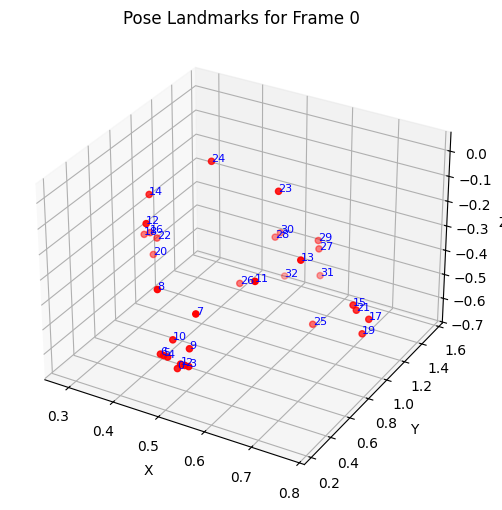

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1. Read the CSV file
df = pd.read_csv('./DataLogger/change_wrt_global/pose_landmarks.csv')

# 2. Select which frame to plot (e.g., frame 0)
frame_num = 0
row = df[df['frame'] == frame_num].iloc[0]

# 3. Extract x, y, z for all 33 landmarks
xs = [row[f'landmark{i}_x'] for i in range(33)]
ys = [row[f'landmark{i}_y'] for i in range(33)]
zs = [row[f'landmark{i}_z'] for i in range(33)]

# 4. Make a 3D scatter plot of just the landmarks
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs, c='red', marker='o')

# 5. Annotate each point with its landmark index (0…32)
for i, (x, y, z) in enumerate(zip(xs, ys, zs)):
    ax.text(x, y, z, str(i), fontsize=8, color='blue')

# 6. Label axes and give the plot a title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'Pose Landmarks for Frame {frame_num}')

plt.show()


In [ ]:
"""11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24

are the landmarks of the interest for the media pipe pose tracking model."""
# the code below onll gets the landmarks of interest from the pose tracking csv 

   frame     timestamp  landmark11_x  landmark11_y  landmark11_z  \
0      0  1.748734e+09      0.635650      0.464618     -0.209560   
1      1  1.748734e+09      0.635650      0.464606     -0.149618   
2      2  1.748734e+09      0.635909      0.464619     -0.167026   
3      3  1.748734e+09      0.635910      0.464622     -0.174580   
4      4  1.748734e+09      0.635942      0.464741     -0.169429   

   landmark12_x  landmark12_y  landmark12_z  landmark13_x  landmark13_y  ...  \
0      0.401436      0.471668     -0.110928      0.679980      0.710158  ...   
1      0.402565      0.470786     -0.056255      0.681646      0.714793  ...   
2      0.402943      0.470525     -0.058848      0.685718      0.722234  ...   
3      0.403179      0.470263     -0.060969      0.685608      0.722629  ...   
4      0.403191      0.470271     -0.053702      0.685187      0.722797  ...   

   landmark19_z  landmark20_x  landmark20_y  landmark20_z  landmark23_x  \
0     -0.530776      0.300823      

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, FFMpegWriter

# ─── 1. LOAD THE NEW CSV ─────────────────────────────────────────────────────────
df = pd.read_csv('./DataLogger/change_wrt_global/pose_landmarks_only_interested.csv')

# Verify that 'frame' is present
if 'frame' not in df.columns:
    raise ValueError("CSV must have a 'frame' column.")

# Extract the set of landmark‐indices that actually appear in this CSV
landmark_indices = sorted({
    int(col.split('_')[0].replace('landmark',''))
    for col in df.columns
    if col.startswith('landmark') and col.endswith('_x')
})
# Example: [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24]

# ─── 2. DEFINE MEDIAPIPE POSE CONNECTIONS AND FILTER ───────────────────────────────
ALL_POSE_CONNECTIONS = [
    (0,1), (1,2), (2,3), (3,7),
    (0,4), (4,5), (5,6), (6,8),
    (9,10), (11,12),
    (11,13), (13,15), (12,14), (14,16),
    (15,17), (17,19), (19,15),
    (16,18), (18,20), (20,16),
    (11,23), (12,24), (23,24),
    (23,25), (25,27), (24,26), (26,28),
    (27,29), (29,31), (28,30), (30,32)
]

# Keep only those connections for which both endpoints are in our landmark_indices
POSE_EDGES = [
    (a, b) for (a, b) in ALL_POSE_CONNECTIONS
    if (a in landmark_indices and b in landmark_indices)
]
# For example: [(11,12), (11,13), (13,15), (12,14), (14,16), (15,17), (17,19),
#               (19,15), (16,18), (18,20), (20,16), (11,23), (12,24), (23,24)]

# ─── 3. GATHER ALL UNIQUE FRAME NUMBERS ────────────────────────────────────────────
all_frames = sorted(df['frame'].unique())

# (Optional) To shorten the animation, skip frames via a step > 1
step = 1
frame_list = all_frames[::step]

# ─── 4. SET UP THE 3D SCATTER PLOT ─────────────────────────────────────────────────
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Initialize using the first frame
first_frame = frame_list[0]
row0 = df[df['frame'] == first_frame].iloc[0]

# Build coordinate lists for only the landmarks we care about
xs0 = [row0[f'landmark{i}_x'] for i in landmark_indices]
ys0 = [row0[f'landmark{i}_y'] for i in landmark_indices]
zs0 = [row0[f'landmark{i}_z'] for i in landmark_indices]

# 4a. Create the scatter of points
scatter = ax.scatter(xs0, ys0, zs0, c='red', marker='o')

# 4b. Create a text annotation for each landmark (use the actual landmark index as label)
annotations = []
for idx, lm_index in enumerate(landmark_indices):
    x, y, z = xs0[idx], ys0[idx], zs0[idx]
    txt = ax.text(x, y, z, str(lm_index), fontsize=8, color='blue')
    annotations.append(txt)

# 4c. Create line‐objects for each valid POSE_EDGE (connecting two landmarks)
lines = []
# Build a lookup dict for the initial frame: landmark_index → (x, y, z)
coords0 = {
    i: (row0[f'landmark{i}_x'], row0[f'landmark{i}_y'], row0[f'landmark{i}_z'])
    for i in landmark_indices
}

for (a, b) in POSE_EDGES:
    xa, ya, za = coords0[a]
    xb, yb, zb = coords0[b]
    # Plot an initial line segment between (a) and (b)
    (line,) = ax.plot([xa, xb], [ya, yb], [za, zb], c='green', linewidth=2)
    lines.append(line)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
title_text = ax.set_title(f'Frame {first_frame}')

# (Optional) Fix axis limits to cover the full range of your data:
# x_min, x_max = df[[f'landmark{i}_x' for i in landmark_indices]].min().min(), df[[f'landmark{i}_x' for i in landmark_indices]].max().max()
# y_min, y_max = df[[f'landmark{i}_y' for i in landmark_indices]].min().min(), df[[f'landmark{i}_y' for i in landmark_indices]].max().max()
# z_min, z_max = df[[f'landmark{i}_z' for i in landmark_indices]].min().min(), df[[f'landmark{i}_z' for i in landmark_indices]].max().max()
# ax.set_xlim(x_min, x_max)
# ax.set_ylim(y_min, y_max)
# ax.set_zlim(z_min, z_max)

# ─── 5. DEFINE THE UPDATE FUNCTION ─────────────────────────────────────────────────
def update(frame_num):
    """
    Called for each frame in the animation. This moves the scatter, the annotations,
    and updates each line between connected landmarks.
    """
    row = df[df['frame'] == frame_num].iloc[0]
    
    # Build a dict: landmark_index → (x, y, z) at this frame
    coords = {
        i: (row[f'landmark{i}_x'], row[f'landmark{i}_y'], row[f'landmark{i}_z'])
        for i in landmark_indices
    }
    
    # 5a. Update scatter:
    xs = [coords[i][0] for i in landmark_indices]
    ys = [coords[i][1] for i in landmark_indices]
    zs = [coords[i][2] for i in landmark_indices]
    scatter._offsets3d = (xs, ys, zs)
    
    # 5b. Move each annotation to new position
    for idx, lm_index in enumerate(landmark_indices):
        x, y, z = coords[lm_index]
        ann = annotations[idx]
        ann.set_position((x, y))
        ann.set_3d_properties(z, zdir='z')
    
    # 5c. Update each "bone" line between connected landmarks
    for edge_idx, (a, b) in enumerate(POSE_EDGES):
        xa, ya, za = coords[a]
        xb, yb, zb = coords[b]
        line = lines[edge_idx]
        line.set_data([xa, xb], [ya, yb])           # Update x & y
        line.set_3d_properties([za, zb], zdir='z')  # Update z
    
    # 5d. Update the title text
    title_text.set_text(f'Frame {frame_num}')
    
    return (scatter, *annotations, *lines, title_text)

# ─── 6. CREATE AND SAVE THE ANIMATION ──────────────────────────────────────────────
anim = FuncAnimation(
    fig,
    update,
    frames=frame_list,
    interval=50,   # milliseconds between frames (≈20 fps if step=1)
    blit=False
)

# 6a. Save as MP4 (requires ffmpeg in your PATH)
output_mp4 = 'trajectory_with_skeleton.mp4'
print(f"Saving MP4 to '{output_mp4}' ...")
writer = FFMpegWriter(fps=20, metadata=dict(artist='ChatGPT'))
anim.save(output_mp4, writer=writer)
print("Done saving MP4.")

plt.close(fig)


Saving MP4 to 'trajectory_with_skeleton.mp4' ...
Done saving MP4.


In [ ]:
# old animation code using the dots in 3d full body pose tracking

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, FFMpegWriter, PillowWriter

# ─── 1. LOAD THE CSV ─────────────────────────────────────────────────────────────
df = pd.read_csv('/mnt/data/pose_landmarks.csv')

# Make sure there is a 'frame' column
if 'frame' not in df.columns:
    raise ValueError("CSV must have a 'frame' column.")

# Get a sorted list of all unique frame indices
all_frames = sorted(df['frame'].unique())

# ─── 2. (OPTIONAL) SUBSAMPLE TO REDUCE LENGTH ─────────────────────────────────────
# If you have thousands of frames, you may want to skip frames to keep the animation from being too long.
# Change `step = 1` to another integer to skip. For example, step=5 will use only every 5th frame.
step = 1
frame_list = all_frames[::step]

# ─── 3. SET UP THE 3D PLOT ────────────────────────────────────────────────────────
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Pick the very first frame to initialize the scatter + annotations
first_frame = frame_list[0]
row0 = df[df['frame'] == first_frame].iloc[0]

# Extract (x, y, z) for landmarks 0…32
xs0 = [row0[f'landmark{i}_x'] for i in range(33)]
ys0 = [row0[f'landmark{i}_y'] for i in range(33)]
zs0 = [row0[f'landmark{i}_z'] for i in range(33)]

# Create the initial scatter
scatter = ax.scatter(xs0, ys0, zs0, c='red', marker='o')

# Create text annotations for each point (landmark index)
annotations = []
for i, (x, y, z) in enumerate(zip(xs0, ys0, zs0)):
    txt = ax.text(x, y, z, str(i), fontsize=8, color='blue')
    annotations.append(txt)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
title_text = ax.set_title(f'Frame {first_frame}')

# Adjust the axes limits (optional: set these to cover the full range of your data)
# You could compute min/max once across all frames, e.g.:
#   x_min, x_max = df[[f'landmark{i}_x' for i in range(33)]].min().min(), df[[f'landmark{i}_x' for i in range(33)]].max().max()
#   y_min, y_max = ...
#   z_min, z_max = ...
# and then call ax.set_xlim(x_min, x_max), etc. For simplicity, let Matplotlib autoscale here.

# ─── 4. DEFINE THE UPDATE FUNCTION ─────────────────────────────────────────────────
def update(frame_num):
    """
    This function will be called by FuncAnimation for each new frame.
    It should update the scatter (and annotation) coordinates.
    """
    row = df[df['frame'] == frame_num].iloc[0]
    xs = [row[f'landmark{i}_x'] for i in range(33)]
    ys = [row[f'landmark{i}_y'] for i in range(33)]
    zs = [row[f'landmark{i}_z'] for i in range(33)]
    
    # Update the scatter’s internal data
    scatter._offsets3d = (xs, ys, zs)
    
    # Move each annotation to the new (x, y, z) location
    for i, ann in enumerate(annotations):
        ann.set_position((xs[i], ys[i]))           # 2D position (for x,y)
        ann.set_3d_properties(zs[i], zdir='z')      # update the z‐property

    # Update the title
    title_text.set_text(f'Frame {frame_num}')
    return (scatter, *annotations, title_text)

# ─── 5. CREATE THE ANIMATION ──────────────────────────────────────────────────────
# You can control interval (ms between frames) and whether to blit. 
anim = FuncAnimation(
    fig,
    update,
    frames=frame_list,
    interval=50,   # 50 ms between frames ⇒ ~20 fps if step=1
    blit=False
)

# ─── 6. SAVE AS MP4 (REQUIRES ffmpeg) ──────────────────────────────────────────────
output_mp4 = 'trajectory.mp4'
print(f"Saving MP4 to '{output_mp4}' ...")

# Use FFMpegWriter; make sure ffmpeg is installed on your system.
writer = FFMpegWriter(fps=20, metadata=dict(artist='ChatGPT'))
anim.save(output_mp4, writer=writer)
print("Done saving MP4.")

# ─── 7. (OPTIONAL) SAVE AS GIF INSTEAD ──────────────────────────────────────────────
# If you’d rather have a GIF, uncomment the lines below. GIFs can be very large for thousands of frames.
#
# output_gif = 'trajectory.gif'
# print(f"Saving GIF to '{output_gif}' ...")
# writer_gif = PillowWriter(fps=20)
# anim.save(output_gif, writer=writer_gif)
# print("Done saving GIF.")

plt.close(fig)
